In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle, os

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import LSTM, Dense, GRU, Dropout, Bidirectional
from keras.callbacks import ModelCheckpoint, EarlyStopping


from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.svm import *

import seaborn as sns

2025-11-15 16:28:59.372954: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
VERSION = 'v2'
metrics_list = []

In [3]:
df = pd.read_csv('../../dataset/csv/dataset_v2.csv')
df.head(3)


,class,x1,y1,z1,v1,x2,y2,z2,v2,x3,...,y74,z74,v74,x75,y75,z75,v75,face_d75,face_s75,hand_s75
0,celinguk,0.515382,0.146067,0.110489,0.991586,0.492822,0.146987,-0.306285,0.994753,0.583330,...,0.719623,-0.075180,0.353278,0.681209,0.719623,-0.075180,0.353278,0.0,1.0,0.0
1,celinguk,0.588917,0.166224,0.116611,0.981934,0.524755,0.146380,-0.193987,0.988952,0.552517,...,0.639301,0.344269,0.393705,0.699179,0.639301,0.344269,0.393705,0.0,1.0,1.0
2,celinguk,0.540433,0.145536,0.037206,0.990441,0.505499,0.144599,-0.328299,0.995738,0.600953,...,0.679823,-0.150806,0.291771,0.627676,0.679823,-0.150806,0.291771,0.0,1.0,0.0


In [4]:
df[df.isnull().any(axis=1)]

,class,x1,y1,z1,v1,x2,y2,z2,v2,x3,...,y74,z74,v74,x75,y75,z75,v75,face_d75,face_s75,hand_s75


In [5]:
df['class'].value_counts()



class
celinguk       200
diam           200
tutupmuka      200
tutuptangan    200
nodong         200
Name: count, dtype: int64

In [6]:
X = df.drop('class', axis=1) # features
y = df['class'] # target value

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1234)

print(f"Train set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
y_test

Train set size: 850
Test set size: 150


681    tutuptangan
990         nodong
155       celinguk
768    tutuptangan
438      tutupmuka
          ...     
987         nodong
67        celinguk
375           diam
137       celinguk
148       celinguk
Name: class, Length: 150, dtype: object

# SVC : Training Model

In [7]:
model = make_pipeline(StandardScaler(), SVC(probability=True)).fit(X_train, y_train)
y_probs = model.predict_proba(X_train)

In [8]:

path = f'../../model/trained/svc/'
os.makedirs(os.path.dirname(path), exist_ok=True)

with open(f'{path}/svc_model_{VERSION}.pkl', 'wb') as f:
    pickle.dump(model, f)


Classification Report (Training Data):
              precision    recall  f1-score   support

    celinguk     0.9821    0.9706    0.9763       170
        diam     0.9351    1.0000    0.9665       173
      nodong     0.9337    0.9337    0.9337       166
   tutupmuka     0.9748    0.9281    0.9509       167
 tutuptangan     1.0000    0.9885    0.9942       174

    accuracy                         0.9647       850
   macro avg     0.9652    0.9642    0.9643       850
weighted avg     0.9653    0.9647    0.9647       850



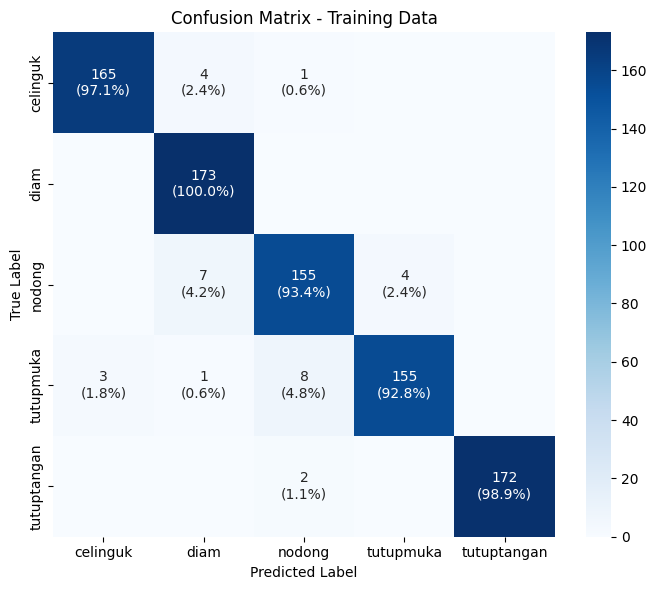

In [9]:
y_pred = model.predict(X_train)

print("\nClassification Report (Training Data):")
print(classification_report(y_train, y_pred, digits=4))

cm = confusion_matrix(y_train, y_pred, labels=np.unique(y_train))
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = (cm / cm_sum.astype(float)) * 100

report_dict = classification_report(y_train, y_pred, digits=4, output_dict=True)

macro_precision = report_dict['macro avg']['precision']
macro_recall = report_dict['macro avg']['recall']
accuracy = report_dict['accuracy']
macro_f1 = report_dict['macro avg']['f1-score']

metrics_list.append({
    'svc': {
        'precision': macro_precision,
        'recall': macro_recall,
        'accuracy': accuracy,
        'f1-score': macro_f1
    }
})

annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_perc[i, j]
        if c == 0:
            annot[i, j] = ""
        else:
            annot[i, j] = f"{c}\n({p:.1f}%)"

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm,
    annot=annot,
    fmt='',
    cmap='Blues',
    cbar=True,
    xticklabels=np.unique(y_train),
    yticklabels=np.unique(y_train)
)
plt.title('Confusion Matrix - Training Data')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


In [10]:
print(metrics_list)

[{'svc': {'precision': 0.9651711398665253, 'recall': 0.9641945269508883, 'accuracy': 0.9647058823529412, 'f1-score': 0.9643373292422239}}]


# Training Model : LSTM SINGLE

In [11]:
# Separate features (X) and labels (y)
X_raw = df.iloc[:, 1:].values
y_raw = df['class'].values

# Encode Labels (for multi-class classification)
# Assuming 'diam' is just one class and there might be others in a full dataset
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_raw)
N_CLASSES = len(label_encoder.classes_)

# Scale Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

In [12]:
def plot_training_history(history, title):
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    

def evaluate_model(model, X_test, y_test, title, label_encoder=label_encoder):
    print(f"\n{'='*60}")
    print(f"{title} - Evaluation Results")
    print("="*60)

    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {accuracy*100:.2f}%")

    y_pred = model.predict(X_test, verbose=0)

    if y_test.ndim > 1 and y_test.shape[1] > 1:
        y_true = np.argmax(y_test, axis=1)
    else:
        y_true = y_test

    y_pred_classes = np.argmax(y_pred, axis=1)

    if label_encoder is not None:
        y_true_labels = label_encoder.inverse_transform(y_true)
        y_pred_labels = label_encoder.inverse_transform(y_pred_classes)
        target_names = label_encoder.classes_
    else:
        y_true_labels = y_true
        y_pred_labels = y_pred_classes
        target_names = None

    

    # 2. Get Classification Report as a Dictionary (Key Change!)
    report_dict = classification_report(y_true_labels, y_pred_labels, 
                                        digits=4, 
                                        output_dict=True, # This returns a dictionary
                                        zero_division=0)
    
    macro_precision = report_dict['macro avg']['precision']
    macro_recall = report_dict['macro avg']['recall']
    macro_f1 = report_dict['macro avg']['f1-score']

    metrics_list.append({
        title: {
            'precision': macro_precision,
            'recall': macro_recall,
            'accuracy': accuracy,
            'f1-score': macro_f1,
        }
    })

    print("\nClassification Report:")
    print(classification_report(y_true_labels, y_pred_labels, digits=4))


    cm = confusion_matrix(y_true_labels, y_pred_labels, labels=target_names)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = (cm / cm_sum.astype(float)) * 100

    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if c == 0:
                annot[i, j] = ""
            else:
                annot[i, j] = f"{c}\n({p:.1f}%)"

    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', cbar=True,
                xticklabels=target_names, yticklabels=target_names)
    plt.title(f'{title} - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

In [13]:
# Reshape for LSTM (Single Timestep) ---
# Format: [samples, timesteps, features]
N_SAMPLES = X_scaled.shape[0]
N_FEATURES_PER_SAMPLE = X_scaled.shape[1]
N_TIMESTEPS = 1 # Each row is treated as one observation with one timestep

X_reshaped = X_scaled.reshape(N_SAMPLES, N_TIMESTEPS, N_FEATURES_PER_SAMPLE)

In [14]:
if N_CLASSES > 2:
    y_final = tf.keras.utils.to_categorical(y_encoded, num_classes=N_CLASSES)
    loss_fn = 'categorical_crossentropy'
    output_activation = 'softmax'
else:
    # If it's effectively binary (N_CLASSES=2), we still use sparse_categorical_crossentropy 
    # since we kept y_encoded as integer labels
    y_final = y_encoded
    loss_fn = 'sparse_categorical_crossentropy'
    # If N_CLASSES=2, the Dense layer should have 1 unit with 'sigmoid' for binary_crossentropy
    # or N_CLASSES units with 'softmax' for categorical_crossentropy. 
    # Since we use sparse_categorical_crossentropy with integer labels, N_CLASSES with 'softmax' is safest.
    output_activation = 'softmax'

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y_final, test_size=0.2, random_state=42, stratify=y_final
)

In [16]:
lstm_model = Sequential([
    # Single LSTM Layer (no return_sequences since it's the last recurrent layer)
    LSTM(units=128, activation='relu', input_shape=(N_TIMESTEPS, N_FEATURES_PER_SAMPLE)),
    Dropout(0.3),
    # Output Dense layer
    Dense(units=N_CLASSES, activation=output_activation)
])

I0000 00:00:1763195481.623475   79413 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
/mnt/c/users/nawfal/documents/apps/Collaborative_Project/suspicious_detection/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
KERAS_MODEL_FILENAME = f'../../model/trained/lstm_s/single_lstm_weights_{VERSION}.best.keras'

checkpoint_cb = ModelCheckpoint(
    filepath=KERAS_MODEL_FILENAME, 
    monitor='val_loss', 
    save_best_only=True, 
    mode='min', 
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=100,   
    restore_best_weights=True, 
    mode='min',
    verbose=1
)

lstm_model.compile(
    optimizer='adam',
    loss=loss_fn,
    metrics=['accuracy']
)

print(f"\nModel Input Shape: {X_train.shape[1:]}")
print(f"Model Output Classes: {N_CLASSES}")
print("-" * 100)
lstm_model.summary()
print("-" * 100)

# Training (using the split training data)
print("Starting Model Training...")
history_lstm = lstm_model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=4,
    verbose=0,
    validation_split=0.2,
    callbacks=[checkpoint_cb, earlystop_cb]
)
print("Model Training Complete.")
print("-" * 100)


Model Input Shape: (1, 345)
Model Output Classes: 5
----------------------------------------------------------------------------------------------------


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │       242,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,333 (950.52 KB)

 Trainable params: 243,333 (950.52 KB)

 Non-trainable params: 0 (0.00 B)

----------------------------------------------------------------------------------------------------
Starting Model Training...


2025-11-15 16:31:25.268931: I external/local_xla/xla/service/service.cc:163] XLA service 0x30813030 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-15 16:31:25.268992: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-11-15 16:31:25.401155: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-15 16:31:25.789655: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
I0000 00:00:1763195488.124121   80031 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_loss improved from None to 0.71337, saving model to ../../model/trained/lstm_s/single_lstm_weights_v2.best.keras

Epoch 2: val_loss improved from 0.71337 to 0.52056, saving model to ../../model/trained/lstm_s/single_lstm_weights_v2.best.keras

Epoch 3: val_loss improved from 0.52056 to 0.31829, saving model to ../../model/trained/lstm_s/single_lstm_weights_v2.best.keras

Epoch 4: val_loss improved from 0.31829 to 0.17462, saving model to ../../model/trained/lstm_s/single_lstm_weights_v2.best.keras

Epoch 5: val_loss improved from 0.17462 to 0.15207, saving model to ../../model/trained/lstm_s/single_lstm_weights_v2.best.keras

Epoch 6: val_loss did not improve from 0.15207

Epoch 7: val_loss did not improve from 0.15207

Epoch 8: val_loss did not improve from 0.15207

Epoch 9: val_loss improved from 0.15207 to 0.11459, saving model to ../../model/trained/lstm_s/single_lstm_weights_v2.best.keras

Epoch 10: val_loss did not improve from 0.11459

Epoch 11: val_loss did not im

In [18]:
# Since TensorFlow models don't pickle reliably, we save the trained 
# Keras model separately and then pickle a dictionary containing the necessary 
# preprocessing objects.

PICKLE_FILENAME = f'lstm_model_{VERSION}.pkl'
KERAS_MODEL_FILENAME = f'../../model/trained/lstm_s/lstm_weights_{VERSION}.keras'

# 8a. Save the Keras model in its native format
lstm_model.save(KERAS_MODEL_FILENAME)

# 8b. Create a dictionary of necessary artifacts
artifacts = {
    'scaler': scaler,
    'label_encoder': label_encoder,
    'model_filename': KERAS_MODEL_FILENAME,
    'input_shape': X_train.shape[1:],
    'num_classes': N_CLASSES
}

# 8c. Pickle the artifacts dictionary
with open(f'../../model/trained/lstm_s/{PICKLE_FILENAME}', 'wb') as file:
    pickle.dump(artifacts, file)

print(f"Preprocessing artifacts (Scaler, Encoder) saved to: {PICKLE_FILENAME}")
print(f"Trained Keras model weights saved to: {KERAS_MODEL_FILENAME}")
print("\nTo load and use this model, you'll need both files and the TensorFlow code to load the .keras file.")

Preprocessing artifacts (Scaler, Encoder) saved to: lstm_model_v2.pkl
Trained Keras model weights saved to: ../../model/trained/lstm_s/lstm_weights_v2.keras

To load and use this model, you'll need both files and the TensorFlow code to load the .keras file.



s-ltsm - Evaluation Results
Test Accuracy: 95.50%

Classification Report:
              precision    recall  f1-score   support

    celinguk     0.9714    0.8500    0.9067        40
        diam     1.0000    1.0000    1.0000        40
      nodong     0.9512    0.9750    0.9630        40
   tutupmuka     0.8864    0.9750    0.9286        40
 tutuptangan     0.9750    0.9750    0.9750        40

    accuracy                         0.9550       200
   macro avg     0.9568    0.9550    0.9546       200
weighted avg     0.9568    0.9550    0.9546       200



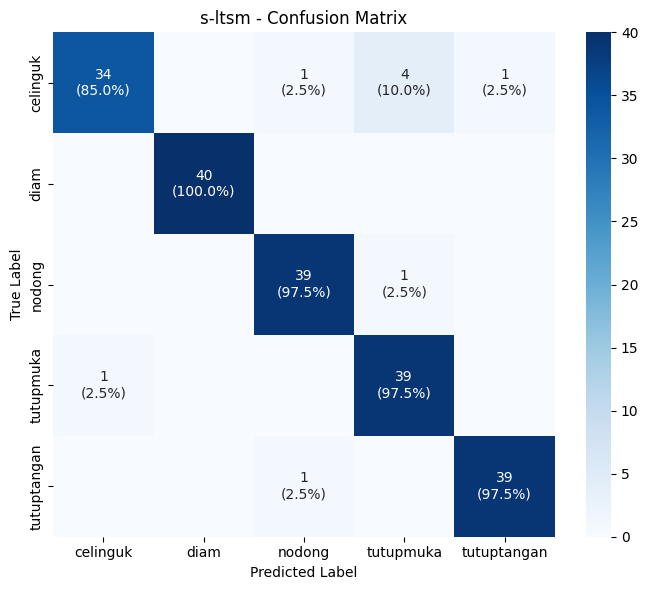

In [19]:
evaluate_model(lstm_model, X_test, y_test, "s-ltsm")

In [20]:
print(metrics_list)

[{'svc': {'precision': 0.9651711398665253, 'recall': 0.9641945269508883, 'accuracy': 0.9647058823529412, 'f1-score': 0.9643373292422239}}, {'s-ltsm': {'precision': 0.956802343997466, 'recall': 0.9550000000000001, 'accuracy': 0.9549999833106995, 'f1-score': 0.9546402116402115}}]


# BILSTM : Training Model

In [21]:
bilstm_model = Sequential([
    # Bi-LSTM Layer: Wrap LSTM in Bidirectional
    Bidirectional(LSTM(
        units=128,          # Number of units for EACH direction (Forward and Backward)
        activation='relu'
    ), input_shape=(N_TIMESTEPS, N_FEATURES_PER_SAMPLE)),
    
    Dropout(0.3),
    
    # Dense layers for classification
    Dense(units=64, activation='relu'),
    Dense(units=N_CLASSES, activation=output_activation)
])

/mnt/c/users/nawfal/documents/apps/Collaborative_Project/suspicious_detection/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [22]:
KERAS_MODEL_FILENAME = f'../../model/trained/lstm_bi/bi_lstm_weights_{VERSION}.best.keras'

checkpoint_cb = ModelCheckpoint(
    filepath=KERAS_MODEL_FILENAME, 
    monitor='val_loss', 
    save_best_only=True, 
    mode='min', 
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=100,   
    restore_best_weights=True, 
    mode='min',
    verbose=1
)

bilstm_model.compile(
    optimizer='adam',
    loss=loss_fn,
    metrics=['accuracy']
)

print(f"Model Input Shape: {X_train.shape[1:]}")
print(f"Model Output Classes: {N_CLASSES}")
print("-" * 50)
bilstm_model.summary()
print("-" * 50)

print("Starting BiLSTM Model Training...")
# Train the model
history_bilstm = bilstm_model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=4,
    validation_split=0.2,
    verbose=0,
    callbacks=[checkpoint_cb, earlystop_cb]
)
print("Model Training Complete.")
print("-" * 50)

# Evaluate the model
loss, accuracy = bilstm_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print("-" * 50)

Model Input Shape: (1, 345)
Model Output Classes: 5
--------------------------------------------------


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 256)            │       485,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 502,149 (1.92 MB)

 Trainable params: 502,149 (1.92 MB)

 Non-trainable params: 0 (0.00 B)

--------------------------------------------------
Starting BiLSTM Model Training...

Epoch 1: val_loss improved from None to 0.65787, saving model to ../../model/trained/lstm_bi/bi_lstm_weights_v2.best.keras

Epoch 2: val_loss improved from 0.65787 to 0.40827, saving model to ../../model/trained/lstm_bi/bi_lstm_weights_v2.best.keras

Epoch 3: val_loss improved from 0.40827 to 0.34764, saving model to ../../model/trained/lstm_bi/bi_lstm_weights_v2.best.keras

Epoch 4: val_loss improved from 0.34764 to 0.34491, saving model to ../../model/trained/lstm_bi/bi_lstm_weights_v2.best.keras

Epoch 5: val_loss improved from 0.34491 to 0.25411, saving model to ../../model/trained/lstm_bi/bi_lstm_weights_v2.best.keras

Epoch 6: val_loss did not improve from 0.25411

Epoch 7: val_loss did not improve from 0.25411

Epoch 8: val_loss did not improve from 0.25411

Epoch 9: val_loss did not improve from 0.25411

Epoch 10: val_loss improved from 0.25411 to 0.20479, saving model to ../../model/trained/l

2025-11-15 16:34:47.618571: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.


Test Accuracy: 96.50%
--------------------------------------------------


In [23]:

PICKLE_FILENAME = f'bi_lstm_model_{VERSION}.pkl'
KERAS_MODEL_FILENAME = f'bi_lstm_weights_{VERSION}.keras'# Recommended native Keras format

# 4a. Save the Keras model in its native format
bilstm_model.save(f'../../model/trained/lstm_bi/{KERAS_MODEL_FILENAME}')

# 4b. Create a dictionary of necessary artifacts (Scaler, Encoder, Model Path)
artifacts = {
    'scaler': scaler,
    'label_encoder': label_encoder,
    'model_filename': KERAS_MODEL_FILENAME,
    'input_shape': X_train.shape[1:],
    'num_classes': N_CLASSES
}

# 4c. Pickle the artifacts dictionary
with open(f'../../model/trained/lstm_bi/{PICKLE_FILENAME}', 'wb') as file:
    pickle.dump(artifacts, file)

print(f"✅ BiLSTM Keras model weights saved to: {KERAS_MODEL_FILENAME}")
print(f"✅ Preprocessing artifacts (Scaler, Encoder) saved to: {PICKLE_FILENAME}")

✅ BiLSTM Keras model weights saved to: bi_lstm_weights_v2.keras
✅ Preprocessing artifacts (Scaler, Encoder) saved to: bi_lstm_model_v2.pkl



bi-ltsm - Evaluation Results
Test Accuracy: 96.50%

Classification Report:
              precision    recall  f1-score   support

    celinguk     0.9722    0.8750    0.9211        40
        diam     1.0000    1.0000    1.0000        40
      nodong     0.9302    1.0000    0.9639        40
   tutupmuka     0.9286    0.9750    0.9512        40
 tutuptangan     1.0000    0.9750    0.9873        40

    accuracy                         0.9650       200
   macro avg     0.9662    0.9650    0.9647       200
weighted avg     0.9662    0.9650    0.9647       200



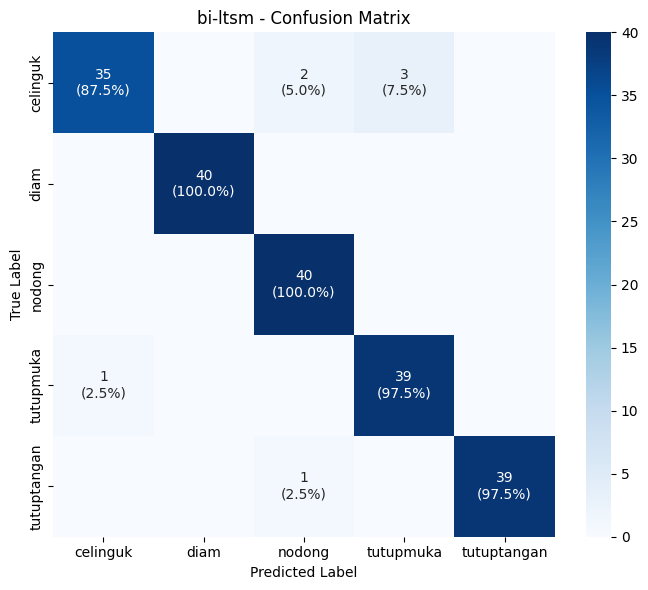

[{'svc': {'precision': 0.9651711398665253, 'recall': 0.9641945269508883, 'accuracy': 0.9647058823529412, 'f1-score': 0.9643373292422239}}, {'s-ltsm': {'precision': 0.956802343997466, 'recall': 0.9550000000000001, 'accuracy': 0.9549999833106995, 'f1-score': 0.9546402116402115}}, {'bi-ltsm': {'precision': 0.9662052417866371, 'recall': 0.9650000000000001, 'accuracy': 0.9649999737739563, 'f1-score': 0.9646938675225429}}]


In [24]:
evaluate_model(bilstm_model, X_test, y_test, "bi-ltsm")
print(metrics_list)

In [ ]:
print("--- Model Metrics ---")
for item in metrics_list:
    # Get the model name and its metrics dictionary
    model_name = list(item.keys())[0]
    metrics = item[model_name]
    
    # Print the model name and metrics dictionary
    print(f"**{model_name.upper()} Metrics:**")
    print(metrics)
    print("-" * 25)

--- Model Metrics ---



KeyboardInterrupt



# GRU : Training Model

In [61]:
# --- 2. Define the Single-Layer GRU Model ---
gru_model = Sequential([
    # GRU Layer - No Bidirectional wrapper requested, so it's unidirectional.
    GRU(
        units=128,          # Number of units in the GRU
        activation='tanh',  # GRU default activation
        input_shape=(N_TIMESTEPS, N_FEATURES_PER_SAMPLE)
    ),
    
    Dropout(0.3),
    
    # Dense layers for classification
    Dense(units=64, activation='relu'),
    Dense(units=N_CLASSES, activation=output_activation)
])

/mnt/c/users/nawfal/documents/apps/Collaborative_Project/suspicious_detection/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [62]:
KERAS_MODEL_FILENAME = f'../../model/trained/gru/gru_weights_{VERSION}.keras'

checkpoint_cb = ModelCheckpoint(
    filepath=KERAS_MODEL_FILENAME, 
    monitor='val_loss', 
    save_best_only=True, 
    mode='min', 
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=100,   
    restore_best_weights=True, 
    mode='min',
    verbose=1
)

gru_model.compile(
    optimizer='adam',
    loss=loss_fn,
    metrics=['accuracy']
)

print(f"Model Input Shape: {X_train.shape[1:]}")
print(f"Model Output Classes: {N_CLASSES}")
print("-" * 50)
gru_model.summary()
print("-" * 50)

print("Starting GRU Model Training...")
# Train the model
history_gru = gru_model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=4,
    validation_split=0.2,
    verbose=0,
    callbacks=[checkpoint_cb, earlystop_cb]
)
print("Model Training Complete.")
print("-" * 50)

# Evaluate the model
loss, accuracy = gru_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print("-" * 50)

Model Input Shape: (1, 345)
Model Output Classes: 5
--------------------------------------------------


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 128)            │       182,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 190,981 (746.02 KB)

 Trainable params: 190,981 (746.02 KB)

 Non-trainable params: 0 (0.00 B)

--------------------------------------------------
Starting GRU Model Training...

Epoch 1: val_loss improved from None to 0.46586, saving model to ../../model/trained/gru/gru_weights_v1.keras

Epoch 2: val_loss improved from 0.46586 to 0.26435, saving model to ../../model/trained/gru/gru_weights_v1.keras

Epoch 3: val_loss improved from 0.26435 to 0.17710, saving model to ../../model/trained/gru/gru_weights_v1.keras

Epoch 4: val_loss did not improve from 0.17710

Epoch 5: val_loss did not improve from 0.17710

Epoch 6: val_loss improved from 0.17710 to 0.06929, saving model to ../../model/trained/gru/gru_weights_v1.keras

Epoch 7: val_loss improved from 0.06929 to 0.05186, saving model to ../../model/trained/gru/gru_weights_v1.keras

Epoch 8: val_loss did not improve from 0.05186

Epoch 9: val_loss did not improve from 0.05186

Epoch 10: val_loss did not improve from 0.05186

Epoch 11: val_loss did not improve from 0.05186

Epoch 12: val_loss did not improve from 0.05186

Epoch 13: v

In [63]:

PICKLE_FILENAME = f'gru_model_{VERSION}.pkl'
KERAS_MODEL_FILENAME = f'gru_weights_{VERSION}.keras'# Recommended native Keras format

# 4a. Save the Keras model in its native format
gru_model.save(f'../../model/trained/gru/{KERAS_MODEL_FILENAME}')

# 4b. Create a dictionary of necessary artifacts (Scaler, Encoder, Model Path)
artifacts = {
    'scaler': scaler,
    'label_encoder': label_encoder,
    'model_filename': KERAS_MODEL_FILENAME,
    'input_shape': X_train.shape[1:],
    'num_classes': N_CLASSES
}

# 4c. Pickle the artifacts dictionary
with open(f'../../model/trained/gru/{PICKLE_FILENAME}', 'wb') as file:
    pickle.dump(artifacts, file)

print(f"✅ GRU Keras model weights saved to: {KERAS_MODEL_FILENAME}")
print(f"✅ Preprocessing artifacts (Scaler, Encoder) saved to: {PICKLE_FILENAME}")

✅ GRU Keras model weights saved to: gru_weights_v1.keras
✅ Preprocessing artifacts (Scaler, Encoder) saved to: gru_model_v1.pkl



gru - Evaluation Results
Test Accuracy: 96.00%

Classification Report:
              precision    recall  f1-score   support

    celinguk     0.9091    1.0000    0.9524        10
        diam     0.9000    0.9000    0.9000        10
      nodong     1.0000    0.9000    0.9474        10
   tutupmuka     1.0000    1.0000    1.0000        10
 tutuptangan     1.0000    1.0000    1.0000        10

    accuracy                         0.9600        50
   macro avg     0.9618    0.9600    0.9599        50
weighted avg     0.9618    0.9600    0.9599        50



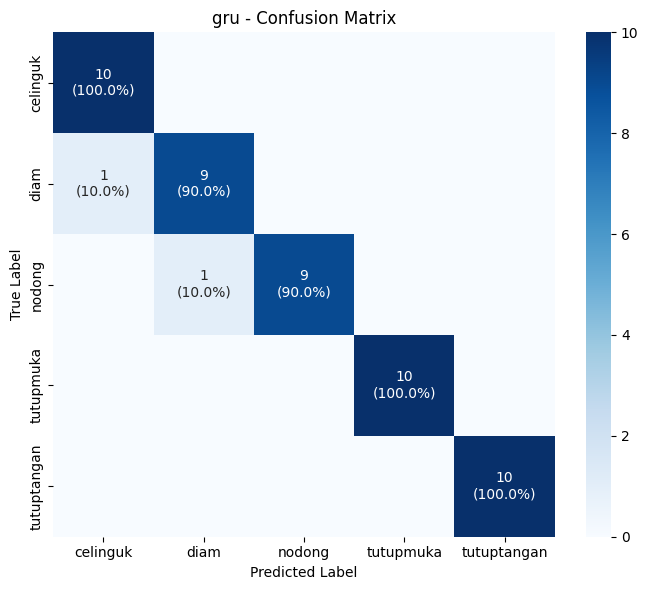

In [64]:
evaluate_model(gru_model, X_test, y_test, "gru")

# NN : Training Model

In [65]:
# --- Configuration ---

# Label Encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_raw)
N_CLASSES = len(label_encoder.classes_)

# Scaling (Crucial for Dense layers)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

N_FEATURES_PER_SAMPLE = X_scaled.shape[1]
N_SAMPLES = X_scaled.shape[0]

# Note: MLP/Dense layers expect 2D data: [samples, features]
# We use X_scaled directly, NOT the 3D X_reshaped used for LSTMs/GRUs.
X_flat = X_scaled

# Final Output Preparation (Using sparse labels with softmax for consistency)
y_final = y_encoded
loss_fn = 'sparse_categorical_crossentropy'
output_activation = 'softmax'

# Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y_final, test_size=0.2, random_state=42, stratify=y_final
)

In [66]:
nn_model = Sequential([
    # Input layer and first Hidden Dense Layer
    Dense(units=256, activation='relu', input_shape=(N_FEATURES_PER_SAMPLE,)),
    Dropout(0.3),
    
    # Second Hidden Dense Layer
    Dense(units=128, activation='relu'),
    Dropout(0.3),
    
    # Output Dense layer (units = number of classes, activation = softmax for classification)
    Dense(units=N_CLASSES, activation=output_activation)
])

/mnt/c/users/nawfal/documents/apps/Collaborative_Project/suspicious_detection/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [67]:
KERAS_MODEL_FILENAME = f'../../model/trained/nn/nn_weights_{VERSION}.keras'

checkpoint_cb = ModelCheckpoint(
    filepath=KERAS_MODEL_FILENAME, 
    monitor='val_loss', 
    save_best_only=True, 
    mode='min', 
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=100,   
    restore_best_weights=True, 
    mode='min',
    verbose=1
)

nn_model.compile(
    optimizer='adam',
    loss=loss_fn,
    metrics=['accuracy']
)

print(f"Model Input Shape (NN/MLP): {X_train.shape[1]}")
print(f"Model Output Classes: {N_CLASSES}")
print("-" * 50)
nn_model.summary()
print("-" * 50)

print("Starting MLP Model Training...")
# Train the model
history_nn = nn_model.fit(
    X_train,
    y_train,
    epochs=100, # Use more epochs than RNNs, as simple layers train faster
    batch_size=4,
    validation_split=0.2,
    verbose=0,
    callbacks=[earlystop_cb, checkpoint_cb]
)
print("Model Training Complete.")
print("-" * 50)

# Evaluate the model
loss, accuracy = nn_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print("-" * 50)

Model Input Shape (NN/MLP): 345
Model Output Classes: 5
--------------------------------------------------


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 256)            │        88,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,117 (477.02 KB)

 Trainable params: 122,117 (477.02 KB)

 Non-trainable params: 0 (0.00 B)

--------------------------------------------------
Starting MLP Model Training...

Epoch 1: val_loss improved from None to 0.31541, saving model to ../../model/trained/nn/nn_weights_v1.keras

Epoch 2: val_loss improved from 0.31541 to 0.22261, saving model to ../../model/trained/nn/nn_weights_v1.keras

Epoch 3: val_loss improved from 0.22261 to 0.18890, saving model to ../../model/trained/nn/nn_weights_v1.keras

Epoch 4: val_loss improved from 0.18890 to 0.16453, saving model to ../../model/trained/nn/nn_weights_v1.keras

Epoch 5: val_loss improved from 0.16453 to 0.07106, saving model to ../../model/trained/nn/nn_weights_v1.keras

Epoch 6: val_loss did not improve from 0.07106

Epoch 7: val_loss did not improve from 0.07106

Epoch 8: val_loss did not improve from 0.07106

Epoch 9: val_loss did not improve from 0.07106

Epoch 10: val_loss did not improve from 0.07106

Epoch 11: val_loss did not improve from 0.07106

Epoch 12: val_loss improved from 0.07106 to 0.06810, saving model to .

In [68]:

PICKLE_FILENAME = f'nn_model_{VERSION}.pkl'
KERAS_MODEL_FILENAME = f'nn_weights_{VERSION}.keras'# Recommended native Keras format

# 4a. Save the Keras model in its native format
nn_model.save(f'../../model/trained/nn/{KERAS_MODEL_FILENAME}')

# 4b. Create a dictionary of necessary artifacts (Scaler, Encoder, Model Path)
artifacts = {
    'scaler': scaler,
    'label_encoder': label_encoder,
    'model_filename': KERAS_MODEL_FILENAME,
    'input_shape': X_train.shape[1:],
    'num_classes': N_CLASSES
}

# 4c. Pickle the artifacts dictionary
with open(f'../../model/trained/nn/{PICKLE_FILENAME}', 'wb') as file:
    pickle.dump(artifacts, file)

print(f"✅ NN Keras model weights saved to: {KERAS_MODEL_FILENAME}")
print(f"✅ Preprocessing artifacts (Scaler, Encoder) saved to: {PICKLE_FILENAME}")

✅ NN Keras model weights saved to: nn_weights_v1.keras
✅ Preprocessing artifacts (Scaler, Encoder) saved to: nn_model_v1.pkl



neural network - Evaluation Results
Test Accuracy: 94.00%

Classification Report:
              precision    recall  f1-score   support

    celinguk     1.0000    0.8000    0.8889        10
        diam     0.7692    1.0000    0.8696        10
      nodong     1.0000    0.9000    0.9474        10
   tutupmuka     1.0000    1.0000    1.0000        10
 tutuptangan     1.0000    1.0000    1.0000        10

    accuracy                         0.9400        50
   macro avg     0.9538    0.9400    0.9412        50
weighted avg     0.9538    0.9400    0.9412        50



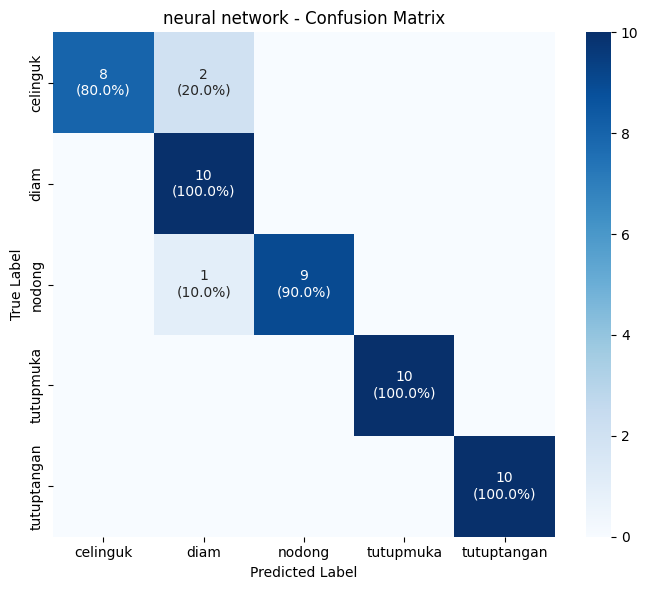

[{'svc': {'precision': 0.97580833800346, 'recall': 0.975982776089159, 'accuracy': 0.9764150943396226, 'f1-score': 0.9757863629127058}}, {'s-ltsm': {'precision': 0.9818181818181818, 'recall': 0.9800000000000001, 'accuracy': 0.9800000190734863, 'f1-score': 0.9799498746867169}}, {'bi-ltsm': {'precision': 0.9618181818181817, 'recall': 0.96, 'accuracy': 0.9599999785423279, 'f1-score': 0.9599498746867168}}, {'gru': {'precision': 0.9618181818181817, 'recall': 0.96, 'accuracy': 0.9599999785423279, 'f1-score': 0.9599498746867168}}, {'neural network': {'precision': 0.9538461538461538, 'recall': 0.9400000000000001, 'accuracy': 0.9399999976158142, 'f1-score': 0.9411645054665648}}]


In [69]:
evaluate_model(nn_model, X_test, y_test, "neural network")
print(metrics_list)

# Visualization

/tmp/ipykernel_26797/3789410225.py:58: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


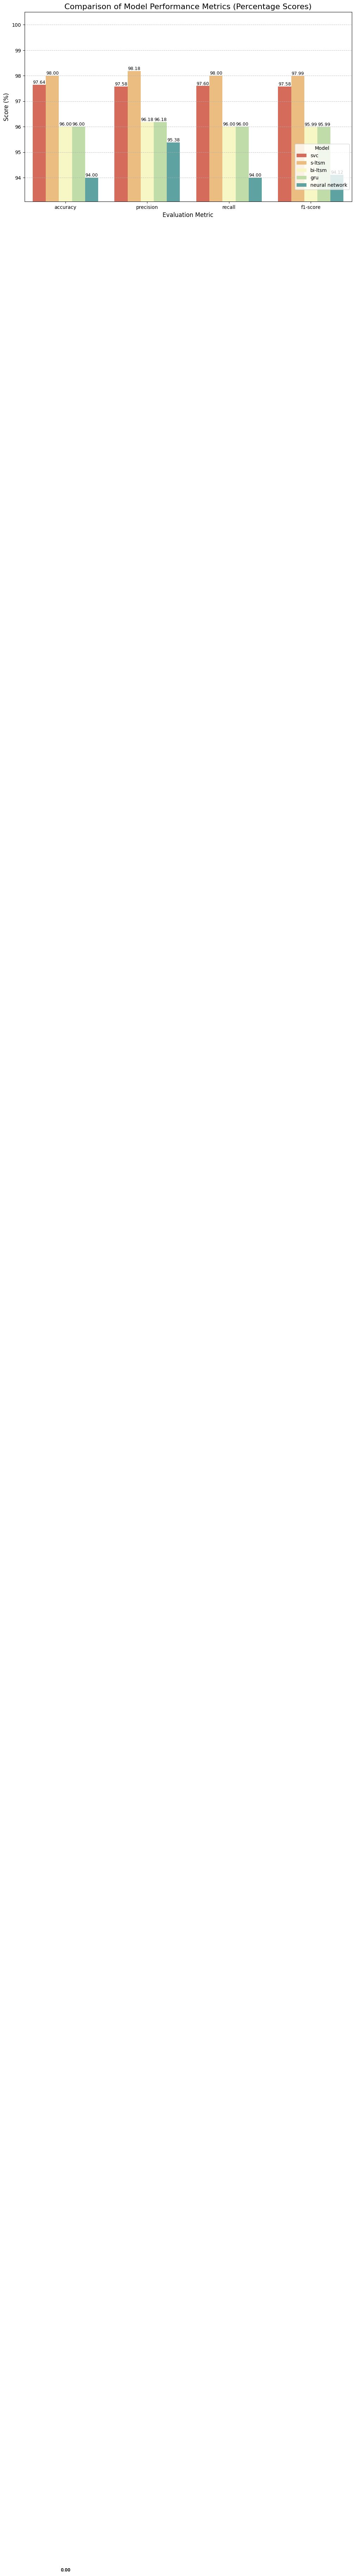

In [70]:
records = []
for model_dict in metrics_list:
    for model_name, metrics in model_dict.items():
        # Convert scores to percentages (e.g., 0.97 -> 97.00)
        for key in metrics:
            metrics[key] *= 100
        record = {'Model': model_name}
        record.update(metrics)
        records.append(record)

df = pd.DataFrame(records)

#creating grouped bar charts using seaborn
df_long = df.melt(
    id_vars='Model',
    value_vars=['accuracy', 'precision', 'recall', 'f1-score'],
    var_name='Metric',
    value_name='Score'
)

plt.figure(figsize=(12, 7))

# Use 'Metric' for the x-axis, and 'Model' for the hue (side-by-side bars)
sns.barplot(
    x='Metric',
    y='Score',
    hue='Model',
    data=df_long,
    palette='Spectral' # Choose a color palette for distinct model colors
)

# 4. Add labels, title, and formatting
plt.title('Comparison of Model Performance Metrics (Percentage Scores)', fontsize=16)
plt.xlabel('Evaluation Metric', fontsize=12)
plt.ylabel('Score (%)', fontsize=12)

# Adjust y-axis limits for better visual comparison
min_score = df_long['Score'].min() * 0.99
plt.ylim(min_score, 100.5)  

# Add value labels on top of the bars
for p in plt.gca().patches:
    score = p.get_height()
    if not np.isnan(score):
        plt.gca().text(
            p.get_x() + p.get_width() / 2.,
            score,
            f'{score:.2f}',
            fontsize=9,
            color='black',
            ha='center',
            va='bottom'
        )

# Move legend to a convenient spot
plt.legend(title='Model', loc='lower right', bbox_to_anchor=(1.0, 0.05))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()




## LSTM

In [26]:
X_raw = df.iloc[:, 1:].values
y_raw = df['class'].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_raw)
N_CLASSES = len(label_encoder.classes_)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

N_SAMPLES = X_scaled.shape[0]
N_FEATURES_PER_SAMPLE = X_scaled.shape[1]
N_TIMESTEPS = 1

X_reshaped = X_scaled.reshape(N_SAMPLES, N_TIMESTEPS, N_FEATURES_PER_SAMPLE)

if N_CLASSES > 2:
    y_final = tf.keras.utils.to_categorical(y_encoded, num_classes=N_CLASSES)
    loss_fn = 'categorical_crossentropy'
    output_activation = 'softmax'
else:
    y_final = y_encoded
    loss_fn = 'sparse_categorical_crossentropy'
    output_activation = 'softmax'

X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y_final, test_size=0.2, random_state=42, stratify=y_final
)

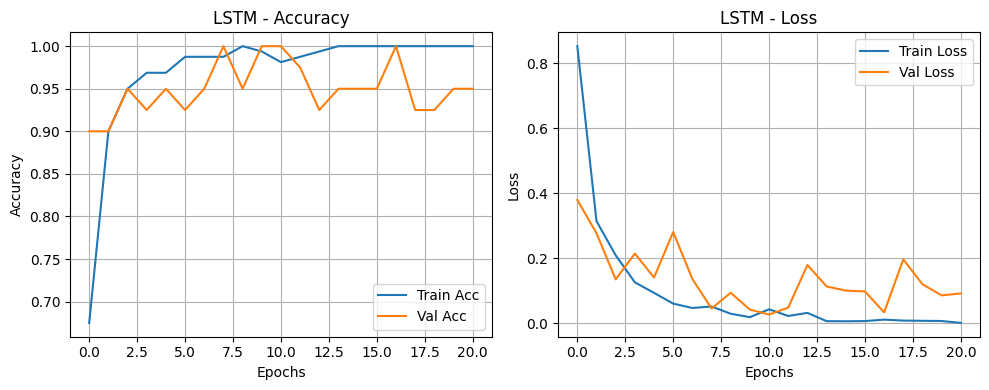

In [25]:
plot_training_history(history_lstm, "LSTM")


LSTM - Evaluation Results
Test Accuracy: 98.00%

Classification Report:
              precision    recall  f1-score   support

    celinguk     1.0000    1.0000    1.0000        10
        diam     0.9091    1.0000    0.9524        10
      nodong     1.0000    0.9000    0.9474        10
   tutupmuka     1.0000    1.0000    1.0000        10
 tutuptangan     1.0000    1.0000    1.0000        10

    accuracy                         0.9800        50
   macro avg     0.9818    0.9800    0.9799        50
weighted avg     0.9818    0.9800    0.9799        50



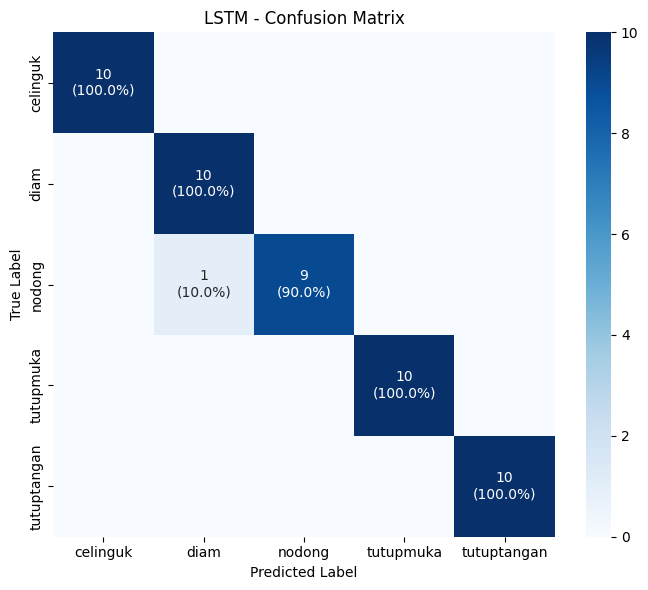

In [27]:
evaluate_model(lstm_model, X_test, y_test, "LSTM")

## BI-LSTM

In [29]:
X_raw = df.iloc[:, 1:].values
y_raw = df['class'].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_raw)
N_CLASSES = len(label_encoder.classes_)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

N_SAMPLES = X_scaled.shape[0]
N_FEATURES_PER_SAMPLE = X_scaled.shape[1]
N_TIMESTEPS = 1

X_reshaped = X_scaled.reshape(N_SAMPLES, N_TIMESTEPS, N_FEATURES_PER_SAMPLE)

if N_CLASSES > 2:
    y_final = tf.keras.utils.to_categorical(y_encoded, num_classes=N_CLASSES)
    loss_fn = 'categorical_crossentropy'
    output_activation = 'softmax'
else:
    y_final = y_encoded
    loss_fn = 'sparse_categorical_crossentropy'
    output_activation = 'softmax'

X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y_final, test_size=0.2, random_state=42, stratify=y_final
)

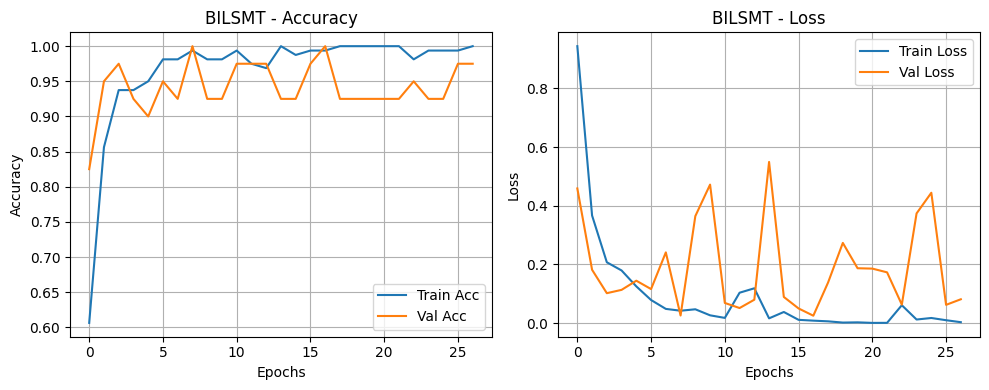

In [31]:
plot_training_history(history_bilstm, "BILSMT")


BI-LSTM - Evaluation Results
Test Accuracy: 98.00%

Classification Report:
              precision    recall  f1-score   support

    celinguk     1.0000    1.0000    1.0000        10
        diam     0.9091    1.0000    0.9524        10
      nodong     1.0000    0.9000    0.9474        10
   tutupmuka     1.0000    1.0000    1.0000        10
 tutuptangan     1.0000    1.0000    1.0000        10

    accuracy                         0.9800        50
   macro avg     0.9818    0.9800    0.9799        50
weighted avg     0.9818    0.9800    0.9799        50



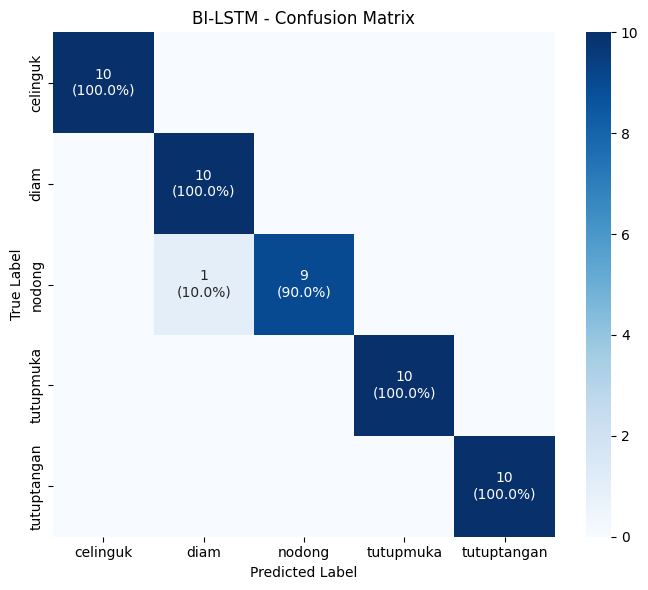

In [30]:
evaluate_model(bilstm_model, X_test, y_test, "BI-LSTM")

## GRU

In [32]:
X_raw = df.iloc[:, 1:].values
y_raw = df['class'].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_raw)
N_CLASSES = len(label_encoder.classes_)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

N_SAMPLES = X_scaled.shape[0]
N_FEATURES_PER_SAMPLE = X_scaled.shape[1]
N_TIMESTEPS = 1

X_reshaped = X_scaled.reshape(N_SAMPLES, N_TIMESTEPS, N_FEATURES_PER_SAMPLE)

if N_CLASSES > 2:
    y_final = tf.keras.utils.to_categorical(y_encoded, num_classes=N_CLASSES)
    loss_fn = 'categorical_crossentropy'
    output_activation = 'softmax'
else:
    y_final = y_encoded
    loss_fn = 'sparse_categorical_crossentropy'
    output_activation = 'softmax'

X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y_final, test_size=0.2, random_state=42, stratify=y_final
)

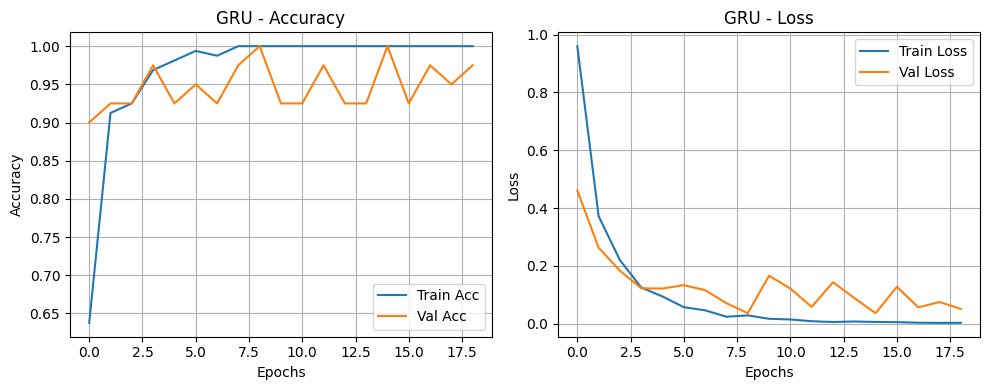

In [33]:
plot_training_history(history_gru, "GRU")


GRU - Evaluation Results
Test Accuracy: 96.00%

Classification Report:
              precision    recall  f1-score   support

    celinguk     0.9091    1.0000    0.9524        10
        diam     0.9000    0.9000    0.9000        10
      nodong     1.0000    0.9000    0.9474        10
   tutupmuka     1.0000    1.0000    1.0000        10
 tutuptangan     1.0000    1.0000    1.0000        10

    accuracy                         0.9600        50
   macro avg     0.9618    0.9600    0.9599        50
weighted avg     0.9618    0.9600    0.9599        50



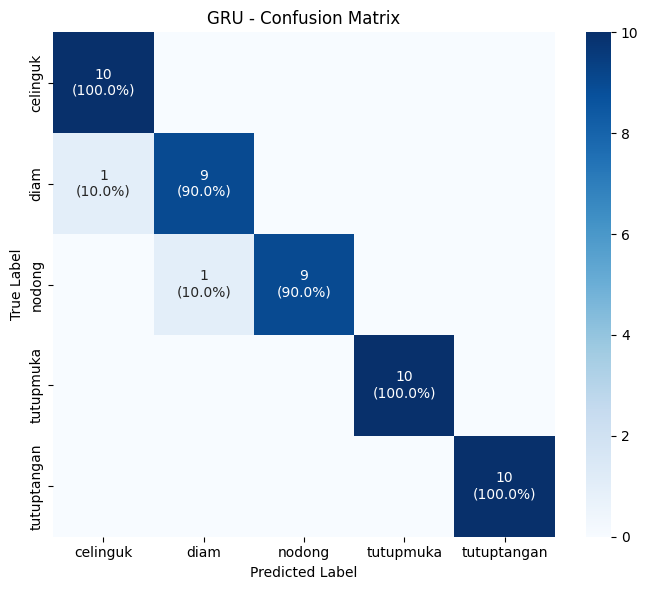

In [34]:
evaluate_model(gru_model, X_test, y_test, "GRU")

## NN

In [36]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_raw)
N_CLASSES = len(label_encoder.classes_)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

N_FEATURES_PER_SAMPLE = X_scaled.shape[1]
N_SAMPLES = X_scaled.shape[0]

X_flat = X_scaled

y_final = y_encoded
loss_fn = 'sparse_categorical_crossentropy'
output_activation = 'softmax'

X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y_final, test_size=0.2, random_state=42, stratify=y_final
)

X_train = X_train.squeeze()
X_test = X_test.squeeze()

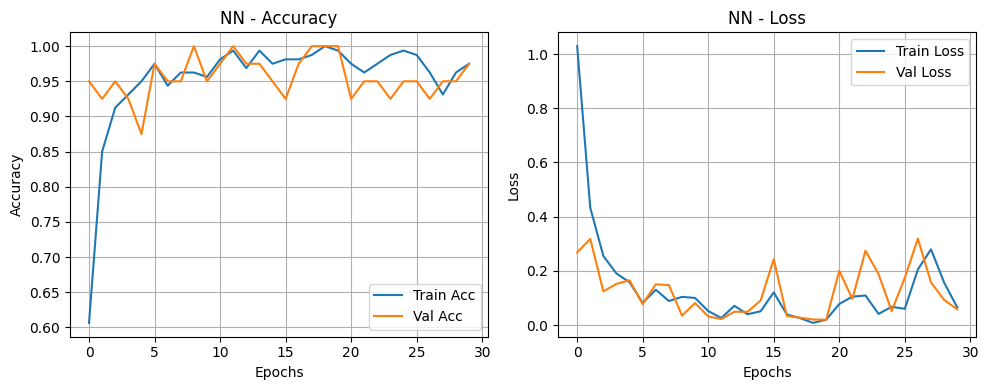

In [37]:
plot_training_history(history_nn, "NN")


NN - Evaluation Results
Test Accuracy: 96.00%

Classification Report:
              precision    recall  f1-score   support

    celinguk     1.0000    0.8000    0.8889        10
        diam     0.8333    1.0000    0.9091        10
      nodong     1.0000    1.0000    1.0000        10
   tutupmuka     1.0000    1.0000    1.0000        10
 tutuptangan     1.0000    1.0000    1.0000        10

    accuracy                         0.9600        50
   macro avg     0.9667    0.9600    0.9596        50
weighted avg     0.9667    0.9600    0.9596        50



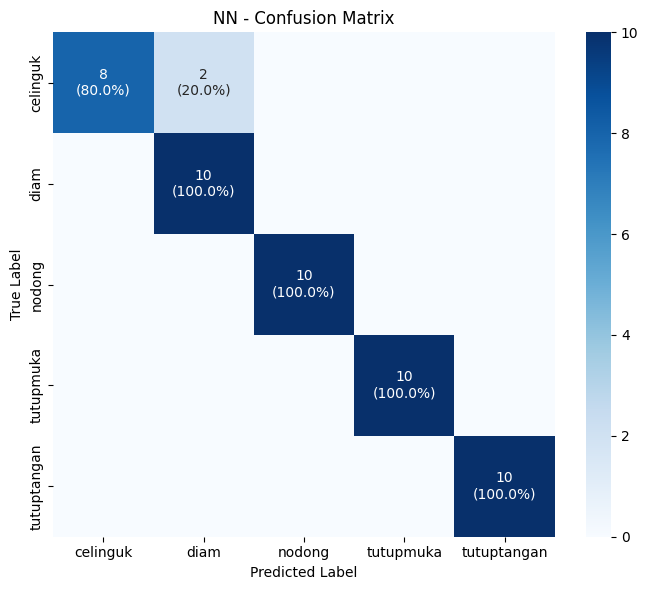

In [38]:
evaluate_model(nn_model, X_test, y_test, "NN")